In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import svm
import matplotlib.pyplot as plt
import pickle

In [20]:
dfSampled = pd.io.parsers.read_csv("LibSVM_data/D-shifts_UniquePepSampled_ForPaperSCXLumos_ThermoUltimate3000_130m.standardized.csv")

In [21]:
lStandardizedFeatures = "Dnum NormedRepreEt PeptideLength [K]Ratio".split()

In [22]:
dfSampled.head()

,DEFeatureIdx,Peptide,Charge,SpecEValue,Channel,Quantity,Cosine,NormedApexEtDiff,Dnum,NormedRepreEt,PeptideLength,[K]Ratio,SampleName,Dnum_Standardized,NormedRepreEt_Standardized,PeptideLength_Standardized,[K]Ratio_Standardized
0,1942,AHVIVMAATNRPNSIDPALRR,4,4.625882e-13,1,29263950.0,0.796224,0.000000,2,0.073117,21,0.000000,DE6plex_1_1_1_1_N_J100_NCP1_1228.tsv,-1.178291,-0.887625,0.880152,-1.017750
1,1942,AHVIVMAATNRPNSIDPALRR,4,4.625882e-13,2,20618520.0,0.713655,0.000120,4,0.073117,21,0.000000,DE6plex_1_1_1_1_N_J100_NCP1_1228.tsv,-0.940452,-0.887625,0.880152,-1.017750
2,1942,AHVIVMAATNRPNSIDPALRR,4,4.625882e-13,3,40883710.0,0.761830,0.000120,6,0.073117,21,0.000000,DE6plex_1_1_1_1_N_J100_NCP1_1228.tsv,-0.702613,-0.887625,0.880152,-1.017750
3,1942,AHVIVMAATNRPNSIDPALRR,4,4.625882e-13,4,9100364.0,0.734450,-0.000530,8,0.073117,21,0.000000,DE6plex_1_1_1_1_N_J100_NCP1_1228.tsv,-0.464773,-0.887625,0.880152,-1.017750
4,913,IMQSSSEVGYDAMAGDFVNMVEK,3,3.706209e-23,1,16429420.0,0.733614,0.000635,4,0.945168,23,0.043478,DE6plex_1_1_1_O_J100_NCP1_1228.tsv,-0.940452,1.008125,1.238768,-0.357254


Read from pickle

In [5]:
#with open('CV_results_each_feature.pk', 'rb') as pkfile:
#    dArr = pickle.load(pkfile)


In [6]:
dArr = {}

Draw Benchmark

In [7]:
def draw_benchmark(model, title=None):
    arrPredicted = dArr['arrPredicted' + model]
    arrTestValue = dArr['arrTestValue' + model]
    rmse = np.sqrt(np.mean(((arrPredicted - arrTestValue) ** 2)))
    corr = stats.pearsonr(arrPredicted, arrTestValue)[0]

    print('RMSE: %.5e'%rmse)
    print('Corr: %.5f'%corr)

    left = 0.2
    bottom = 0.2
    width = 0.7
    height = 0.7
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([left, bottom, width, height]) 

    
    ax.set_xlim((-0.015, 0.025))
    ax.set_ylim((-0.015, 0.025))
    ax.set_xticks([-0.01, 0, 0.01, 0.02])
    ax.set_yticks([-0.01, 0, 0.01, 0.02])
    ax.set_xlabel('Predicted RT shift')
    ax.set_ylabel('Real RT shift')
    ax.grid()

    ax.scatter(arrPredicted, arrTestValue,
               alpha=0.02, color='k', marker='o', rasterized=True)

    if title:
        plt.title(title)
    plt.savefig('Predicted_RT_shift_vs_Real_RT_shift_{}.pdf'.format(model), format='pdf', dpi=300)

Test Code

In [8]:
seY100 = dfSampled['NormedApexEtDiff'][:100]
dfX = dfSampled['Dnum_Standardized NormedRepreEt_Standardized PeptideLength_Standardized [K]Ratio_Standardized'.split()]
arrX100 = np.array(dfX)[:100]

In [9]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX100):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.5, C=1.0, gamma=1, cache_size=20000)
    linearModel = reg.fit(arrX100[train_idx], seY100[train_idx])
    arrPredicted = reg.predict(arrX100[test_idx])
    totalSqrError += np.sum((arrPredicted - seY100[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY100[test_idx])
    
arrPredicted = np.concatenate(lPredicted)
arrTestValue = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY100)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY100)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY100))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredicted, arrTestValue)[0])


running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000152373
Root Mean squared error: 0.0039035045
RMSE in Real time scale: 0.2420172794
Pearson corr coef: 0.3623


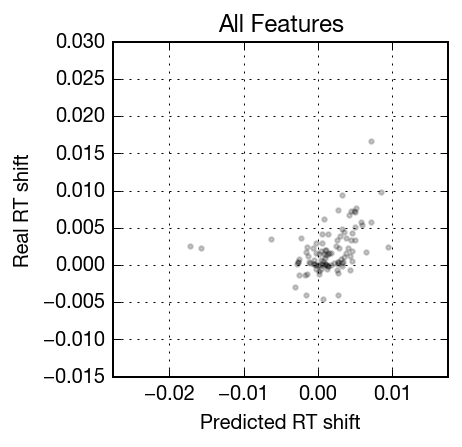

In [10]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111) 
ax.scatter(arrPredicted, arrTestValue,
           alpha=0.2, color='k', marker='.', rasterized=True)

ax.set_title("All Features")
ax.axis('equal')
ax.set_xlabel('Predicted RT shift')
ax.set_ylabel('Real RT shift')

ax.grid()


All

In [24]:
seY = dfSampled['NormedApexEtDiff']
dfX = dfSampled['Dnum_Standardized NormedRepreEt_Standardized PeptideLength_Standardized [K]Ratio_Standardized'.split()]
arrX = np.array(dfX)

In [12]:
arrX

array([[-1.17829147, -0.8876254 ,  0.88015212, -1.01774979],
       [-0.9404521 , -0.8876254 ,  0.88015212, -1.01774979],
       [-0.70261272, -0.8876254 ,  0.88015212, -1.01774979],
       ..., 
       [ 0.01090542, -0.32575925, -0.19569692, -0.00499018],
       [ 0.48658417, -0.32575925, -0.19569692, -0.00499018],
       [ 0.96226293, -0.32575925, -0.19569692, -0.00499018]])

In [13]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.8, C=1.0, gamma='auto', cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedAll = np.concatenate(lPredicted)
arrTestValueAll = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedAll, arrTestValueAll)[0])

dArr['arrPredictedAll'] = arrPredictedAll
dArr['arrTestValueAll'] = arrTestValueAll

running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000030377
Root Mean squared error: 0.0017428962
RMSE in Real time scale: 0.1080595625
Pearson corr coef: 0.6275


RMSE: 1.74290e-03
Corr: 0.62750


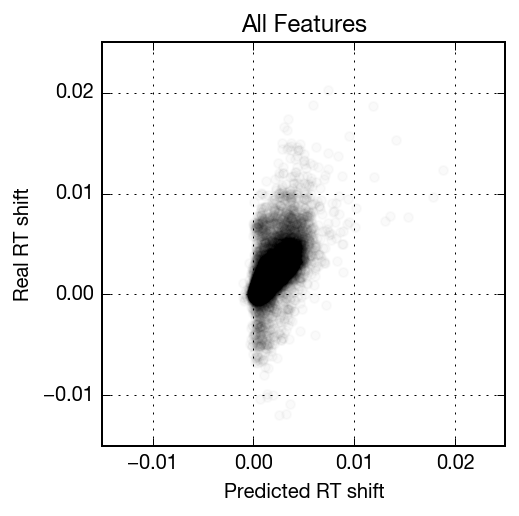

In [14]:
draw_benchmark('All', 'All Features')

In [25]:
dfX.head()

,Dnum_Standardized,NormedRepreEt_Standardized,PeptideLength_Standardized,[K]Ratio_Standardized
0,-1.178291,-0.887625,0.880152,-1.017750
1,-0.940452,-0.887625,0.880152,-1.017750
2,-0.702613,-0.887625,0.880152,-1.017750
3,-0.464773,-0.887625,0.880152,-1.017750
4,-0.940452,1.008125,1.238768,-0.357254


In [26]:
seY = dfSampled['NormedApexEtDiff']
dfX = dfSampled['Dnum_Standardized NormedRepreEt_Standardized PeptideLength_Standardized [K]Ratio_Standardized'.split()]
dfX['NormedRepreEt_Standardized'] = dfX['NormedRepreEt_Standardized'] * 2
arrX = np.array(dfX)

/casa/yeon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
dfX.head()

,Dnum_Standardized,NormedRepreEt_Standardized,PeptideLength_Standardized,[K]Ratio_Standardized
0,-1.178291,-1.775251,0.880152,-1.017750
1,-0.940452,-1.775251,0.880152,-1.017750
2,-0.702613,-1.775251,0.880152,-1.017750
3,-0.464773,-1.775251,0.880152,-1.017750
4,-0.940452,2.016249,1.238768,-0.357254


running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000030182
Root Mean squared error: 0.0017373062
RMSE in Real time scale: 0.1077129839
Pearson corr coef: 0.6294
RMSE: 1.73731e-03
Corr: 0.62944


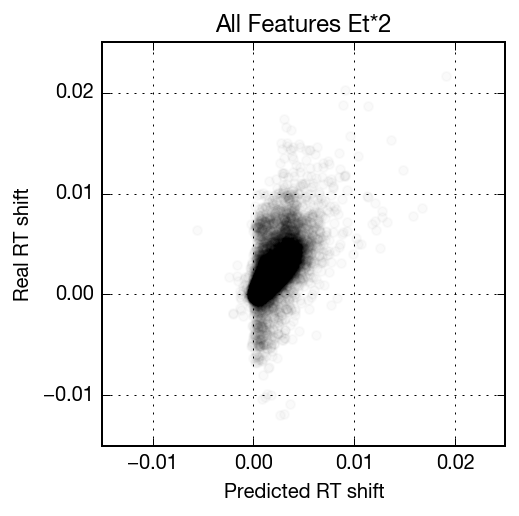

In [28]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.8, C=1.0, gamma='auto', cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedAll = np.concatenate(lPredicted)
arrTestValueAll = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedAll, arrTestValueAll)[0])

dArr['arrPredictedAllEt*2'] = arrPredictedAll
dArr['arrTestValueAllEt*2'] = arrTestValueAll

draw_benchmark('AllEt*2', 'All Features Et*2')

In [29]:
seY = dfSampled['NormedApexEtDiff']
dfX = dfSampled['Dnum_Standardized NormedRepreEt_Standardized PeptideLength_Standardized [K]Ratio_Standardized'.split()]
dfX['NormedRepreEt_Standardized'] = dfX['NormedRepreEt_Standardized'] /2
dfX['[K]Ratio_Standardized'] = dfX['NormedRepreEt_Standardized'] * 10
arrX = np.array(dfX)

/casa/yeon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/casa/yeon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [30]:
dfX.head()

,Dnum_Standardized,NormedRepreEt_Standardized,PeptideLength_Standardized,[K]Ratio_Standardized
0,-1.178291,-0.443813,0.880152,-4.438127
1,-0.940452,-0.443813,0.880152,-4.438127
2,-0.702613,-0.443813,0.880152,-4.438127
3,-0.464773,-0.443813,0.880152,-4.438127
4,-0.940452,0.504062,1.238768,5.040623


running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000031098
Root Mean squared error: 0.0017634592
RMSE in Real time scale: 0.1093344712
Pearson corr coef: 0.6164
RMSE: 1.76346e-03
Corr: 0.61643


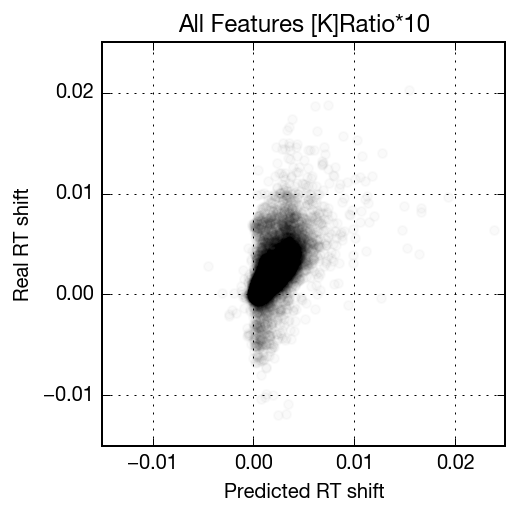

In [31]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.8, C=1.0, gamma='auto', cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedAll = np.concatenate(lPredicted)
arrTestValueAll = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedAll, arrTestValueAll)[0])

dArr['arrPredictedAllKratio*10'] = arrPredictedAll
dArr['arrTestValueAllKratio*10'] = arrTestValueAll

draw_benchmark('AllKratio*10', 'All Features [K]Ratio*10')

In [16]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.9, C=1.0, gamma='auto', cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedAll = np.concatenate(lPredicted)
arrTestValueAll = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedAll, arrTestValueAll)[0])

dArr['arrPredictedAll'] = arrPredictedAll
dArr['arrTestValueAll'] = arrTestValueAll

running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000026939
Root Mean squared error: 0.0016413011
RMSE in Real time scale: 0.1017606673
Pearson corr coef: 0.6789


In [17]:

lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.7, C=1.0, gamma='auto', cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedAll = np.concatenate(lPredicted)
arrTestValueAll = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedAll, arrTestValueAll)[0])

dArr['arrPredictedAll'] = arrPredictedAll
dArr['arrTestValueAll'] = arrTestValueAll


running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000027280
Root Mean squared error: 0.0016516604
RMSE in Real time scale: 0.1024029427
Pearson corr coef: 0.6727


Dnum

In [15]:
seY = dfSampled['NormedApexEtDiff']
dfX = dfSampled['Dnum_Standardized'.split()]
arrX = np.array(dfX)

In [16]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
for train_idx, test_idx in kf.split(arrX):
    reg = svm.NuSVR(kernel='rbf', nu=0.5, C=1.0, gamma=1, cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedDnum = np.concatenate(lPredicted)
arrTestValueDnum = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedDnum, arrTestValueDnum)[0])

dArr['arrPredictedDnum'] = arrPredictedDnum
dArr['arrTestValueDnum'] = arrTestValueDnum
                 


Mean squared error: 0.0000037942
Root Mean squared error: 0.0019478613
RMSE in Real time scale: 0.1207673984
Pearson corr coef: 0.4934


RMSE: 1.94786e-03
Corr: 0.49341


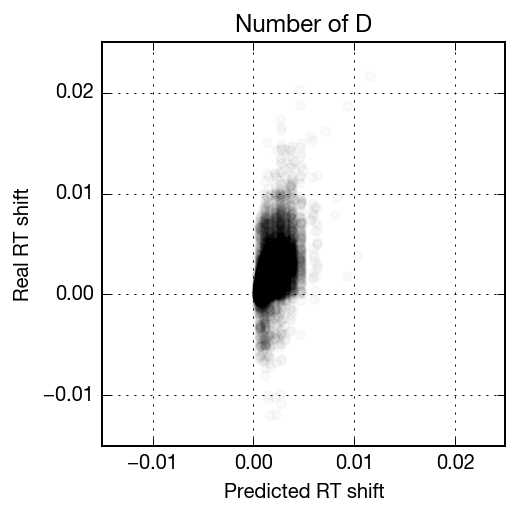

In [17]:
draw_benchmark('Dnum', 'Number of D')

NormedRepreEt

In [18]:
seY = dfSampled['NormedApexEtDiff']
dfX = dfSampled['NormedRepreEt_Standardized'.split()]
arrX = np.array(dfX)

In [19]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.5, C=1.0, gamma=1, cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedEt = np.concatenate(lPredicted)
arrTestValueEt = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedEt, arrTestValueEt)[0])

dArr['arrPredictedEt'] = arrPredictedEt
dArr['arrTestValueEt'] = arrTestValueEt

running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000045482
Root Mean squared error: 0.0021326601
RMSE in Real time scale: 0.1322249281
Pearson corr coef: 0.2985


RMSE: 2.13266e-03
Corr: 0.29848


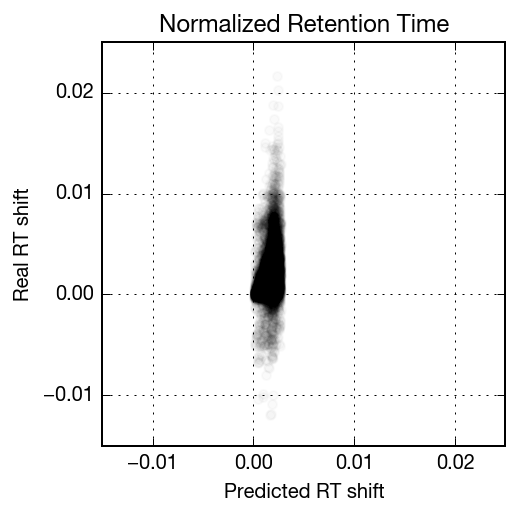

In [20]:
draw_benchmark('Et', 'Normalized Retention Time')

Peptide length

In [21]:
seY = dfSampled['NormedApexEtDiff']
dfX = dfSampled['PeptideLength_Standardized'.split()]
arrX = np.array(dfX)

In [22]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.5, C=1.0, gamma=1, cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedPepLen = np.concatenate(lPredicted)
arrTestValuePepLen = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedPepLen, arrTestValuePepLen)[0])

dArr['arrPredictedPepLen'] = arrPredictedPepLen
dArr['arrTestValuePepLen'] = arrTestValuePepLen

running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000048542
Root Mean squared error: 0.0022032160
RMSE in Real time scale: 0.1365993905
Pearson corr coef: 0.1713


RMSE: 2.20322e-03
Corr: 0.17127


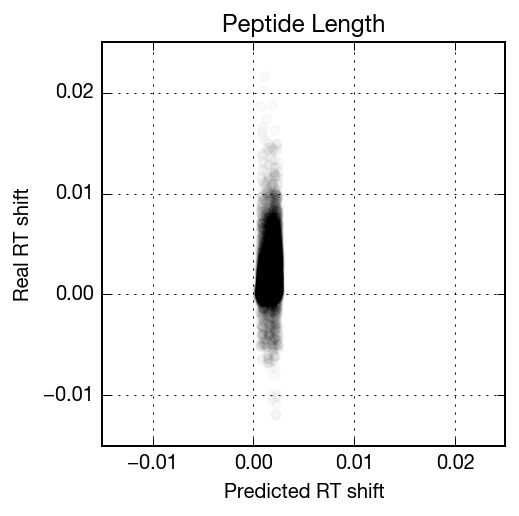

In [23]:
draw_benchmark('PepLen', 'Peptide Length')

[K] Ratio

In [24]:
seY = dfSampled['NormedApexEtDiff']
dfX = dfSampled['PeptideLength_Standardized'.split()]
arrX = np.array(dfX)

In [25]:
lPredicted = []
lTestValue = []

kf = KFold(n_splits=10, shuffle=True)
totalSqrError = 0
n = 0
for train_idx, test_idx in kf.split(arrX):
    n += 1
    print("running %dth fold"%n)
    reg = svm.NuSVR(kernel='rbf', nu=0.5, C=1.0, gamma=1, cache_size=20000)
    linearModel = reg.fit(arrX[train_idx], seY[train_idx])
    arrPredicted = reg.predict(arrX[test_idx])
    totalSqrError += np.sum((arrPredicted - seY[test_idx]) ** 2)
    
    lPredicted.append(arrPredicted)
    lTestValue.append(seY[test_idx])
    
arrPredictedRatio = np.concatenate(lPredicted)
arrTestValueRatio = np.concatenate(lTestValue)

print("Mean squared error: %.10f"%(totalSqrError/len(seY)))
print("Root Mean squared error: %.10f"% np.sqrt(totalSqrError/len(seY)))
print("RMSE in Real time scale: %.10f"%(np.sqrt(totalSqrError/len(seY))*62))
print("Pearson corr coef: %.4f"%stats.pearsonr(arrPredictedRatio, arrTestValueRatio)[0])

dArr['arrPredictedRatio'] = arrPredictedRatio
dArr['arrTestValueRatio'] = arrTestValueRatio

running 1th fold
running 2th fold
running 3th fold
running 4th fold
running 5th fold
running 6th fold
running 7th fold
running 8th fold
running 9th fold
running 10th fold
Mean squared error: 0.0000048615
Root Mean squared error: 0.0022048914
RMSE in Real time scale: 0.1367032665
Pearson corr coef: 0.1720


RMSE: 2.20489e-03
Corr: 0.17198


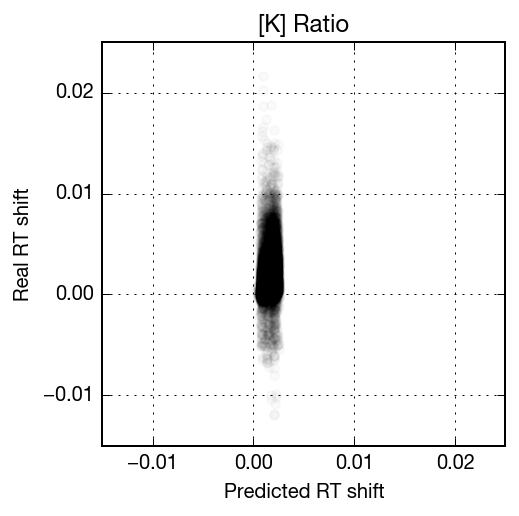

In [26]:
draw_benchmark('Ratio', '[K] Ratio')

Pickling

In [27]:
import pickle

In [28]:
with open('CV_results_each_feature.pk', 'wb') as pkfile:
    pickle.dump({'arrPredictedAll': arrPredictedAll,
                 'arrTestValueAll': arrTestValueAll,
                 
                 'arrPredictedDnum': arrPredictedDnum,
                 'arrTestValueDnum': arrTestValueDnum,
                 
                 'arrPredictedEt': arrPredictedEt,
                 'arrTestValueEt': arrTestValueEt,
                 
                 'arrPredictedPepLen': arrPredictedPepLen,
                 'arrTestValuePepLen': arrTestValuePepLen,
                 
                 'arrPredictedRatio': arrPredictedRatio,
                 'arrTestValueRatio': arrTestValueRatio,
                },
                pkfile)